In [6]:
# --- Imports ---
import os
import glob
import shutil
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib

from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix

# --- Init variables ---
init_folder='/home/traaffneu/margal/awake_code/awake/scripts/'
analysis_folder='/project/4180000.36/AwakeRodent/scratch/RABIES/'

metadata_path = '/home/traaffneu/margal/awake_code/awake/scripts/tables/Awake_metadata.tsv'
metadata_path ='/home/traaffneu/margal/awake_code/awake/scripts/tables/online-ds_metadata_rabies.tsv'

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

print('CHECK Metadata Path:', metadata_path)

CHECK Metadata Path: /home/traaffneu/margal/awake_code/awake/scripts/tables/online-ds_metadata_rabies.tsv


In [7]:
# Create output Directories based on species and regressors

output_dir_mice = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Mice/'
output_dir_rats = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/'

# Mice
if not os.path.exists(output_dir_mice):os.makedirs(output_dir_mice)    
if not os.path.exists(output_dir_mice+'SD_global_signal'):os.makedirs(output_dir_mice+'SD_global_signal')     
if not os.path.exists(output_dir_mice+'SD_global_signal0.1'):os.makedirs(output_dir_mice+'SD_global_signal0.1')      
if not os.path.exists(output_dir_mice+'SD_global_signal0.5'):os.makedirs(output_dir_mice+'SD_global_signal0.5')      
if not os.path.exists(output_dir_mice+'SD_CSF_signal'):os.makedirs(output_dir_mice+'SD_CSF_signal')      
if not os.path.exists(output_dir_mice+'SD_WM_signal'):os.makedirs(output_dir_mice+'SD_WM_signal')     

# Rats 
if not os.path.exists(output_dir_rats):os.makedirs(output_dir_rats)      
if not os.path.exists(output_dir_rats+'SD_global_signal/3D'):os.makedirs(output_dir_rats+'SD_global_signal/3D')     
if not os.path.exists(output_dir_rats+'SD_global_signal0.1/3D'):os.makedirs(output_dir_rats+'SD_global_signal0.1/3D')      
if not os.path.exists(output_dir_rats+'SD_global_signal0.5/3D'):os.makedirs(output_dir_rats+'SD_global_signal0.5/3D')     
if not os.path.exists(output_dir_rats+'SD_CSF_signal/3D'):os.makedirs(output_dir_rats+'SD_CSF_signal/3D')      
if not os.path.exists(output_dir_rats+'SD_WM_signal/3D'):os.makedirs(output_dir_rats+'SD_WM_signal/3D')   

#### Copy scans
- output from first-level analysis within Rabies: RABIES/preprocessed/sub-*/seed-based_connectivity/
- in RABIES/first-level/
- regarless the specie

In [8]:
# Copy scans !

subj_num = '02*'  # Copy all scans from /preprocessed/ subj_num = '*', (only rats online ds) = '04*'
analysis_folder = '/project/4180000.36/AwakeRodent/scratch/RABIES/'
output_dir_mice = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Mice/'
output_dir_rats = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/'

files_to_copy = glob.glob(analysis_folder + f'preprocessed/sub-{subj_num}_*/seed-based_connectivity/*/analysis_datasink/seed_correlation_maps/_split_name_*/*/*.nii.gz')

#for file_path in files_to_copy:
    file_name = os.path.basename(file_path)                                 # Construct the file name
    subject_number = file_path.split('/')[7].split('-')[-2].split('_')[0]   # Extract the subject number from the file path
    regressors = file_path.split('/')[-6] 
    
    if subject_number.startswith(('01', '03')):
        destination_path = os.path.join(output_dir_mice, regressors, file_name)         # Construct the destination file path for Mice
    elif subject_number.startswith(('02', '04')):
        destination_path = os.path.join(output_dir_rats, regressors, file_name)         # Construct the destination file path for Rats
    else:
        print(f"Subject number {subject_number} does not match any category.")
        continue

    # Copy the file to the respective directory
    shutil.copy(file_path, destination_path)

print("Files copied successfully to the respective directories.")


IndentationError: unexpected indent (1225636991.py, line 11)

#### DEFINE VARIABLES

In [9]:
# --- Data path ---
template_rat_path = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template_Masked.nii'
template_mouse_path = '/groupshare/traaffneu/preclinimg/templates/DSURQE/DSURQE_40micron_brain.nii.gz'

# --- Input / Output path ---
input_folder = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/'
output_dir = '/project/4180000.36/AwakeRodent/scratch/second_level/'
base_dir = ['Mice', 'Rats']

# Define the folder structure for each subdirectory
regressor_dir = ['SD_CSF_signal', 'SD_global_signal', 'SD_global_signal01', 'SD_global_signal0.5', 'SD_WM_signal']
results_dir = ['image', 'beta_estimates', 'z_score', 'p_value']

# Create the required directory structure for each subdirectory
for subdir in base_dir:
    sub_dir = os.path.join(output_dir, subdir)
    for sub_dir_name in regressor_dir:
        dir_path = os.path.join(sub_dir, sub_dir_name)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        # Create subdirectories for image, beta, z_score, and p_value
        for sub_sub_dir_name in results_dir:
            sub_sub_dir_path = os.path.join(dir_path, sub_sub_dir_name)
            if not os.path.exists(sub_sub_dir_path):
                os.makedirs(sub_sub_dir_path)

#### SECOND LEVEL ANALYSIS

Dataset: Mice 01001 SD_CSF_signal
Scans included: 8
Done saving
Dataset: Mice 01002 SD_CSF_signal
Scans included: 16
Done saving
Dataset: Mice 01001 SD_global_signal
Scans included: 8
Done saving
Dataset: Mice 01002 SD_global_signal
Scans included: 16
Done saving
Dataset: Mice 01001 SD_global_signal0.1
Scans included: 8
Done saving
Dataset: Mice 01002 SD_global_signal0.1
Scans included: 16
Done saving
Dataset: Mice 01001 SD_global_signal0.5
Scans included: 8
Done saving
Dataset: Mice 01002 SD_global_signal0.5
Scans included: 16
Done saving
Dataset: Mice 01001 SD_WM_signal
Scans included: 8
Done saving
Dataset: Mice 01002 SD_WM_signal
Scans included: 16
Done saving


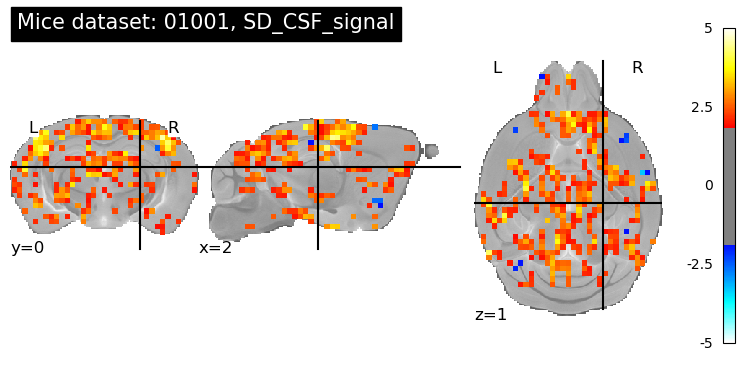

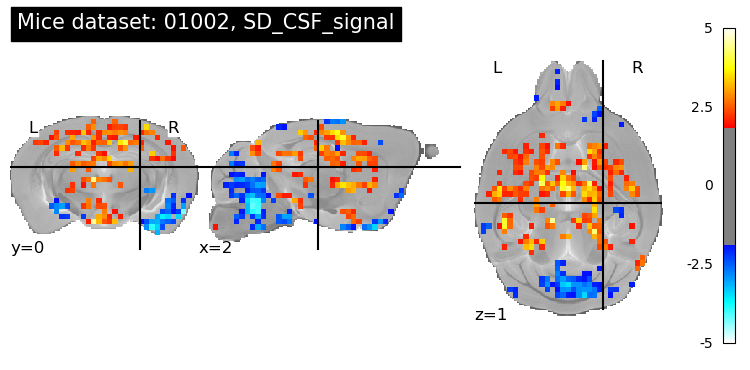

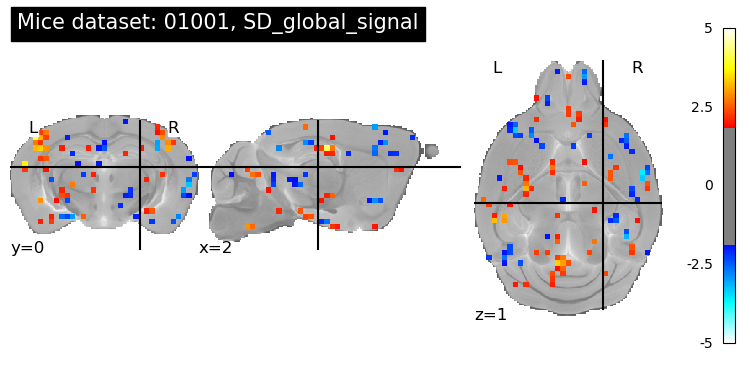

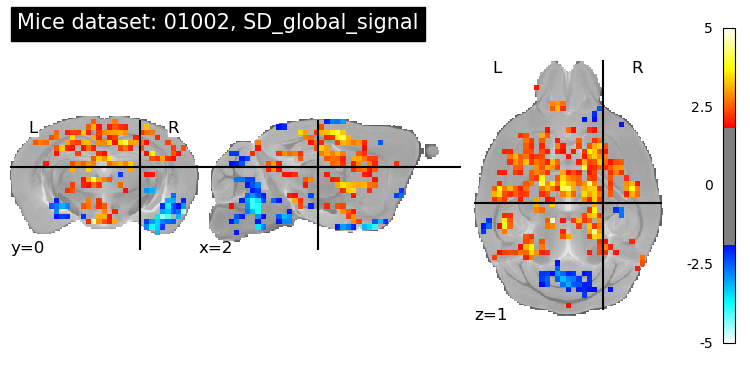

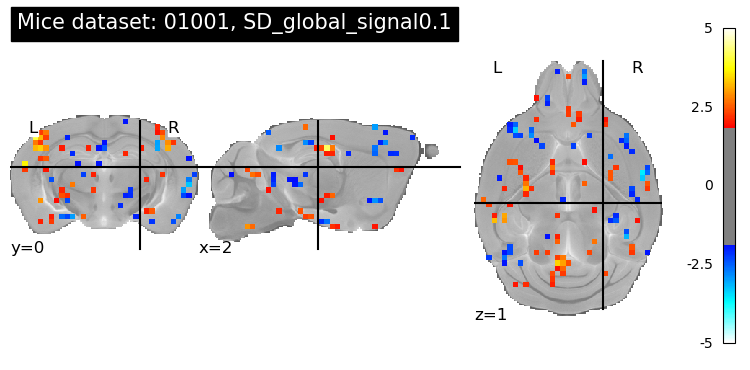

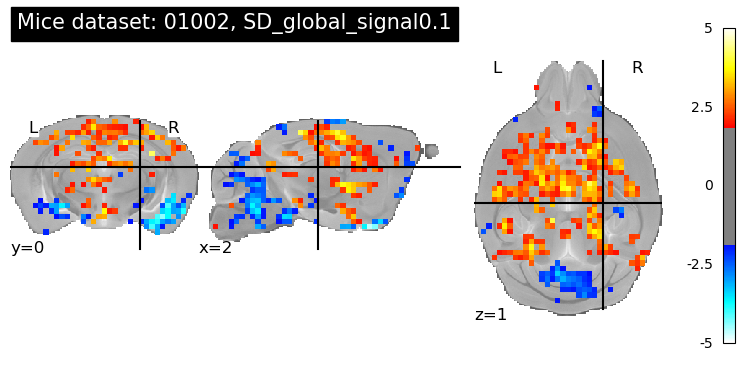

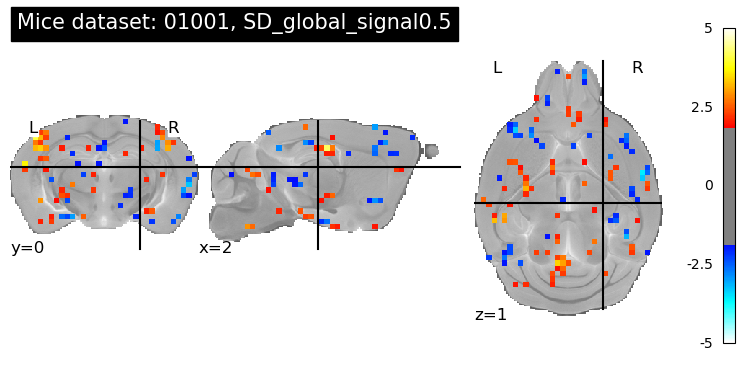

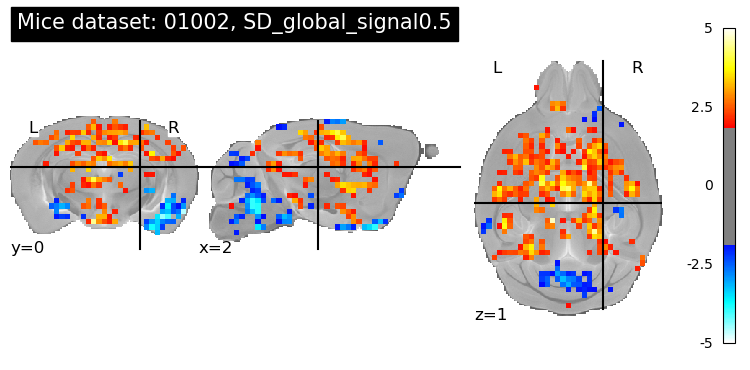

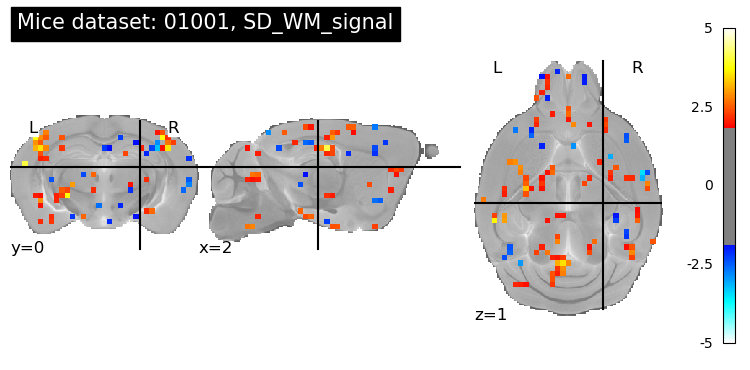

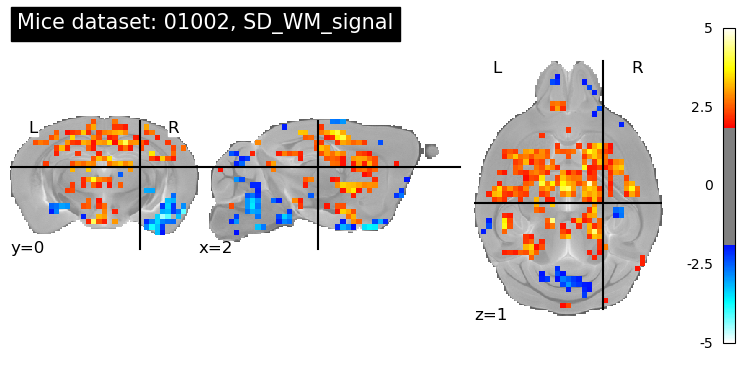

In [12]:
# Define the list of species and signal types
species_list = ['Mice']  #['Mice', 'Rats']

regressors_list = ['SD_CSF_signal', 'SD_global_signal', 'SD_global_signal0.1', 'SD_global_signal0.5', 'SD_WM_signal']
nonexistent_files_df = pd.DataFrame(columns=['File', 'Species', 'Regressor'])

for rodent_specie in species_list:
    for regressor_name in regressors_list:
        for index in range(1, 3):
            
            # --- Load data ---
            if rodent_specie == 'Mice':
                ID = "0"+str(1000+index)
                template = template_mouse_path
                dataset = glob.glob(input_folder + f"Mice/{regressor_name}/sub-{ID}??_*")        
            elif rodent_specie == 'Rats':
                ID = "0"+str(2000+index)
                template = template_rat_path
                dataset = glob.glob(input_folder + f"Rats/{regressor_name}/3D/sub-{ID}??_*")
            else:
                print('Cannot load nifti files, or cannot acess the template.')
                
            # Check if file exist in directory, if not save filename in DataFrame: 
            if not dataset:
                print(f'Directory does not exist for {rodent_specie}, {regressor_name}, subject ID {ID}')
                nonexistent_files_df = nonexistent_files_df.append({'File': dataset, 'Species': rodent_specie, 'Regressor': regressor_name}, ignore_index=True)
                continue
            
            n_subject = len(dataset)
            print("Dataset:", rodent_specie, ID, regressor_name)
            print("Scans included:", n_subject)
            second_level_input = dataset

            # --- Design matrix and second-level model ---
            design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                        columns=["intercept"])
        
            second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                                minimize_memory=False)        #if want to get residuals?

            second_level_model = second_level_model.fit(second_level_input,
                                                        design_matrix=design_matrix)


            # --- Estimate the contrast --- 
            second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

            p_val = 0.05
            
            plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                                bg_img = template,
                                                threshold = 1.9,              
                                                cut_coords= (2 ,0, 1),        
                                                display_mode='ortho',
                                                draw_cross=True,
                                                colorbar=True,
                                                vmax = 5,
                                                black_bg=False, 
                                                title=f"{rodent_specie} dataset: {ID}, {regressor_name}")

            # --- Save outputs ---  
            plt.savefig(output_dir+f'{rodent_specie}/{regressor_name}/image/stat_map_dataset-{ID}_z_score.png') 
            nib.save(second_stat_map['z_score'], output_dir+f'{rodent_specie}/{regressor_name}/z_score/z_score_dataset-{ID}.nii.gz')          
            nib.save(second_stat_map['effect_size'], output_dir+f'{rodent_specie}/{regressor_name}/beta_estimates/beta_dataset-{ID}.nii.gz')            
            nib.save(second_stat_map['p_value'], output_dir+f'{rodent_specie}/{regressor_name}/p_value/p_value_dataset-{ID}.nii.gz')   
            plt.savefig(f'/project/4180000.36/AwakeRodent/scratch/plots/Fig2/dataset-{ID}.svg', format='svg', dpi=800)
            
            print('Done saving')

## Shape

In [11]:
# # --- CURRENT version  --- 

# For Rats' scans only!
# Get the images match the shape /size of the template 

from nilearn.image import resample_to_img

# Define the input and output directories
input_folder = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/'
output_dir_rats = '/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/'
regressor_subfolders = ['SD_global_signal', 'SD_global_signal0.1', 'SD_global_signal0.5', 'SD_CSF_signal', 'SD_WM_signal']

# Define the template path and target shape for resampling
template_rat_path = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template_Masked.nii'
#target_shape = (63, 108, 63)

# Create an empty dataframe to store the subject numbers of scans resampled
resampled_scans_df = pd.DataFrame(columns=['File', 'Subject'])
resampled_scans_df = ['File', 'Subject']
intact_scans_df = ['File', 'Subject']


# Loop over each regressor subfolder
for reg_subfolder in regressor_subfolders:
    subfolder_path = os.path.join(input_folder, reg_subfolder)
    output_subfolder_path = os.path.join(output_dir_rats, reg_subfolder, '3D')
    
    # Create the output reg_subfolder if it doesn't exist
    if not os.path.exists(output_subfolder_path):os.makedirs(output_subfolder_path)
    
    # Loop over each file in the reg_subfolder
    for filename in os.listdir(subfolder_path):
        if filename.endswith('.nii.gz'):
            input_path = os.path.join(subfolder_path, filename)
            output_path = os.path.join(output_subfolder_path, filename)
            img = nib.load(input_path)
            
            # Check if the image is not 3D
            if len(img.shape) == 3:
                print(f"Resampling {filename} to 3D format...")
                resampled_img = resample_to_img(source_img=img, target_img=template_rat_path, interpolation='linear')
                resampled_img.to_filename(output_path)                 
                
                # Extract the subject number from the file name and add it to the dataframe
                subject_number = filename.split('_')[0]
                resampled_scans_df.append({'File': filename, 'Subject': subject_number})
                       
            else:
                #If it's already 3D, just copy it to the output folder
                subject_number = filename.split('_')[0]
                intact_scans_df.append({'File': filename, 'Subject': subject_number})
                os.system(f'cp {input_path} {output_path}')

Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200104_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200105_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200106_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200107_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200108_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200109_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200110_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200111_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200112_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200113_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200114_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200115_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200200_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200201_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200202_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200203_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200204_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200205_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200206_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200207_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200208_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200209_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200210_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200211_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200212_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200213_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200214_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200215_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200216_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200300_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200301_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200302_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200303_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200304_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-1_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200305_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-03_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-01_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-08_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-06_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-05_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-02_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-07_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-04_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Resampling sub-0200307_ses-2_run-09_bold_RAS_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [12]:
print(resampled_scans_df)
print(intact_scans_df)

['File', 'Subject', {'File': 'sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz', 'Subject': 'sub-0200100'}, {'File': 'sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz', 'Subject': 'sub-0200100'}, {'File': 'sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz', 'Subject': 'sub-0200101'}, {'File': 'sub-0200101_ses-1_run-1_bold_autobox_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz', 'Subject': 'sub-0200101'}, {'File': 'sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz', 'Subject': 'sub-0200102'}, {'File': 'sub-0200102_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz', 'Subject': 'sub-0200102'}, {'File': 'sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz', 'Subject': 'sub-0200103'}, {'File': 'sub-0200103_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz', 'Subject': 'sub-0200103'}, {'File': 'sub-02

In [12]:
# --- Old version -> that works --- 
# 
# For Rats' scans only!
# Get the images match the shape /size of the template 

from nilearn.image import resample_to_img

input_folder = "/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/"
output_folder = "/project/4180000.36/AwakeRodent/scratch/RABIES/first_level/Rats/3D"
template_rat_path = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template_Masked.nii'                                                                                                                                                                                                                                  
target_shape = (63, 108, 63)  # The target shape for 3D resampling

# Create the output folder if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith('.nii.gz'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        img = nib.load(input_path)

        # Check if the image is not 3D (4D, 5D, 6D, 7D, etc.)
        if len(img.shape) == 3:
            print('start')

            #volume_to_resample = img.slicer[:, :, :, 0]
            print(f"Resampling {filename} to 3D format...")
           
            target_affine = img.affine  # Keep the original affine

            resampled_img = resample_to_img(source_img=img, target_img=template_rat_path, interpolation='linear')
            #nib.save(resampled_img, output_path)
            resampled_img.to_filename(output_path)
        
        else:
            # If it's already 3D, just copy it to the output folder
            os.system(f'cp {input_path} {output_path}')
            print('already 3D')


start
Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-left_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


start
Resampling sub-0200100_ses-1_run-1_bold_combined_cleaned_seed_S1-right_rat_corr_map.nii.gz to 3D format...


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
